In [1]:
import os, sys
sys.path.append('../')
from xd import *
from run_DMASS import *
from utils import *
import esutil
import healpy as hp
from systematics import *
import fitsio
from cmass_modules import io

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
os.chdir('../../DMASS_XDGMM/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASS_XDGMM/code_py3


In [3]:
from xdgmm import XDGMM as XDGMM_Holoien

In [4]:
def _FindOptimalN_with_err( N, Xdata, Xcov, pickleFileName = None, suffix = None):
    #from sklearn.mixture import GMM
    #data, _ = mixing_color(data, suffix = suffix)
    @pickle_results( pickleFileName )
    def compute_GMM( N, covariance_type='full', n_iter=1000):
        models = [None for n in N]
        for i in range(len(N)):
            sys.stdout.write("\r" + 'Finding optimal number of cluster : {:0.0f} % '\
                             .format(i * 1./len(N) * 100.))
            sys.stdout.flush()
            models[i] = GaussianMixture(n_components=N[i], max_iter=n_iter,
                            covariance_type=covariance_type)
            models[i].fit(Xdata, Xcov)
        return models
    
    models = compute_GMM(N)
    AIC = [m.aic(Xdata) for m in models]
    BIC = [m.bic(Xdata) for m in models]
    i_best = np.argmin(BIC)
    gmm_best = models[i_best]
    sys.stdout.write("\r" + 'Finding optimal number of cluster : {:0.0f} % '\
                     .format(100))
    print("\nbest fit converged:", gmm_best.converged_, end=' ')
    print(" n_components =  %i" % N[i_best])
    return N[i_best], AIC, BIC

In [5]:
def XDnew_fitting_X( X = None, Xcov=None, 
        FileName = None, 
        #init_params = None, 
        #suffix='', 
        #mag = ['MAG_MODEL', 'MAG_DETMODEL'],
        #err = [ 'MAGERR_MODEL','MAGERR_DETMODEL'],
        #filter = ['G', 'R', 'I'],
        n_cl = None, n_iter = 500, tol=1E-5, method='Bovy', verbose=False ):

    

    try: 
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        print ('Using precomputed results from ', FileName)
        return xdgmm_obj
    except FileNotFoundError: pass
    
    if X is None:
        # calling pre-computed model
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        print ('Using precomputed results from ', FileName)
        return xdgmm_obj

    else: 
        if n_cl == None : 
            param_range=np.arange(2, 50, 2)
            optimal_n_comp,_,_= _FindOptimalN_with_err( param_range, X, Xcov, 
            pickleFileName = FileName+'.n_cluster' , suffix = '')
            
            #xdgmm_test = XDGMM_Holoien( n_iter=n_iter, tol=tol, method=method )
            ## Define the range of component numbers, and get ready to compute the BIC for each one:
            #param_range = np.arange(2, 50, 2)
            ## Loop over component numbers, fitting XDGMM model and computing the BIC:
            #bic, optimal_n_comp, lowest_bic = xdgmm_test.bic_test(X, Xcov, param_range)
            ##n_cl = optimal_n_comp[np.argmin(bic)]
        else: optimal_n_comp = n_cl

        #import time
        # fitting
        #initiated class
        xdgmm_obj = XDGMM_Holoien( n_components=optimal_n_comp, n_iter=n_iter, tol=tol, method=method )
        #xdgmm.n_components = optimal_n_comp
        print ('n_components=', optimal_n_comp)
        print ('fitting started. This will take for a while.')
#        t1 = time.time()
        xdgmm_obj = xdgmm_obj.fit(X, Xcov)
        #t2 = time.time()
        print ('fitting finished')
        
        #t3 = time.time()
        print ('saving xdgmm object to.. ', FileName)
        xdgmm_obj.save_model(FileName)
        print ('file saved')
        #print ('saving obj. time:', (t3-t2)%60,'s')
        
        #t4 = time.time()
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        #print ('loading obj. time:', (t4-t3)%60,'s')
#        t2 = time.time()
#        print ('elapsed time:', (t2-t1)/60.0,'s')
        return xdgmm_obj

In [6]:
os.chdir('../../DMASSY3/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASSY3/code_py3


In [7]:
# calling map 
path = '/fs/scratch/PCON0003/warner785/bwarner/'
LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
# 'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits'
#GoldMask = callingEliGoldMask()
LSSMask = LSSGoldmask
GoldMask = LSSGoldmask
LSSMask = LSSMask[LSSMask['DEC']>-3.0 ]
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5_validate/'

In [8]:
# Directory doesn't exist ---- create 
# check for error: print statement 
import os
outdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5_validate//'
if os.path.exists(outdir) == False:
    os.mkdir(outdir)
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5_validate/'

#implement Cuts.keepgoodregion:

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = LSSGoldmask['PIXEL']
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des
    
#gold_st82 = keepGoodRegion(gold_st82)
#print(gold_st82.size)
#gold_spt = keepGoodRegion(gold_spt)
#print(gold_spt.size)

# calling BOSS cmass and applying dmass goodregion mask ----------------------------
#cmass = io.getSGCCMASSphotoObjcat()
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')
train_sample = keepGoodRegion(train_sample)
print('total num of train', train_sample.size)


total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
total num of train 13046


In [9]:
#read in gold catalogs here:
##ST82 REGION catalog:

train_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/'
path =  train_path
train_keyword = 'Y1A1_GOLD_STRIPE82_v2'
    
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP',\
               'SLR_SHIFT_G', 'SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z', 'SLR_SHIFT_Y', 'EBV']

gold_st82 = io.SearchAndCallFits(path = train_path, columns = columns, keyword = train_keyword )
gold_st82 = gold_st82[(gold_st82['MODEST_CLASS'] == 1)&(gold_st82['FLAGS_GOLD'] == 0 )]

gold_st82 = keepGoodRegion(gold_st82)
    
def RemovingSLRReddening(cat):


    if 'SLR_SHIFT_G' not in cat.dtype.names : 
        import numpy.lib.recfunctions as rf   
        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        from y1a1_slr_shiftmap import SLRShift
        zpfile = '/fs/scratch/PCON0003/warner785/bwarner/y1a1_wide_slr_wavg_zpshift2.fit'
        slrshift = SLRShift(zpfile, fill_periphery=True)
        offsets_g = slrshift.get_zeropoint_offset('g',cat['RA'],cat['DEC'],interpolate=True)
        offsets_r = slrshift.get_zeropoint_offset('r',cat['RA'],cat['DEC'],interpolate=True)
        offsets_i = slrshift.get_zeropoint_offset('i',cat['RA'],cat['DEC'],interpolate=True)
        offsets_z = slrshift.get_zeropoint_offset('z',cat['RA'],cat['DEC'],interpolate=True)

        offsets = [ offsets_g, offsets_r, offsets_i, offsets_z  ]
        from pandas import DataFrame, concat
        nametag = ['SLR_SHIFT_'+f for f in ['G', 'R', 'I', 'Z'] ]
        catnametag = cat.dtype.names
        try : 
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat, index = catnametag)
            #del cat['index']
            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
        
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping")
            
            #offsetsdf = np.array(offsetsdf).byteswap().newbyteorder()
            cat = np.array(cat).byteswap().newbyteorder()
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat)

            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
            cat.dtype.names = [str(x) for x in cat.dtype.names]
            
            #matched = pd.merge(desData, goldData, on=key, how=how, suffixes = suffixes, left_index=left_index)


    print('Removing SLR Shift ')
    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  removing SLR from ', mag)
        for b in ['G', 'R', 'I', 'Z']:
            cat[mag + '_'+b] = cat[mag + '_'+b] - cat['SLR_SHIFT'+ '_'+b]

    """
    cat = rf.append_fields(cat, 'SLR_SHIFT_G', offsets_g)
    cat = rf.append_fields(cat, 'SLR_SHIFT_R', offsets_r)
    cat = rf.append_fields(cat, 'SLR_SHIFT_I', offsets_i)
    cat = rf.append_fields(cat, 'SLR_SHIFT_Z', offsets_z)
    """
    return cat

def AddingSFD98Reddening(cat, kind='SPT', coeff = [3.186,2.140,1.569,1.196 ] ):
    import numpy.lib.recfunctions as rf
    import pandas as pd

    band = ['G', 'R', 'I', 'Z']

    if 'EBV' not in cat.dtype.names :   
     
        print('Using SFD98 nside 4096 healpix map')
        print('Bands :',  band)
        #print 'NSIDE = 4096'
        print('coefficients = ', coeff)
        nside = 4096

        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        #sfdfile = '/n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit'
        mapname = '/fs/scratch/PCON0003/warner785/bwarner/ebv_sfd98_fullres_nside_4096_nest_equatorial.fits'
        #mapname = '/n/des/lee.5922/data/systematic_maps/ebv_lenz17_nside_4096_nest_equatorial.fits'
        reddening_ring = hp.read_map(mapname)
        hpIndices = np.arange(reddening_ring.size)
        #goodmask = hp.mask_good(reddening_ring)
        #goldmask = 

        goodIndices = hpIndices #hpIndices[goodmask]
        clean_map = reddening_ring #reddening_ring[goodmask]

        sysMap = np.zeros((clean_map.size, ), dtype=[('PIXEL', 'i4'), ('EBV', 'f8'), ('RA', 'f8'), ('DEC', 'f8')])
        sysMap['PIXEL'] = goodIndices
        sysMap['EBV'] = clean_map
        
        sys_ra, sys_dec = hpHEALPixelToRaDec(goodIndices, nside = nside)
        sysMap['RA'] = sys_ra
        sysMap['DEC'] = sys_dec

        from cmass_modules.Cuts import keepGoodRegion
        sysMap = keepGoodRegion(sysMap)
        if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -30]
        elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -30]


        cat_hp = cat
        hpind = hpRaDecToHEALPixel(cat_hp['RA'], cat_hp['DEC'], nside= 4096, nest= False)
        #cat_hp.dtype.names = [str(x) for x in cat_hp.dtype.names]
        cat_hp = changeColumnName(cat_hp, name = 'HPIX', rename = 'PIXEL')
        cat_hp['PIXEL'] = hpind
        
        #sfdmap = changeColumnName( sysMap_ge, name = 'SIGNAL', rename = 'SFD98' )


        try : 

            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping ....")

            cat_hp = np.array(cat_hp).byteswap().newbyteorder()
            #sfdmap = np.array(sfdmap).byteswap().newbyteorder()
            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            

            #print cat_Data.keys()
            #print sfdData.keys()
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
            
        matched_arr = matched.to_records(index=False)
        matched_arr.dtype.names = [str(x) for x in matched_arr.dtype.names]


    else : matched_arr = cat

    print('Adding SFD98 Shift ')
    print('Bands :',  band)
    print('coefficients = ', coeff)

    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  Adding SFD to ', mag)
        for i,b in enumerate(band):
            matched_arr[mag + '_'+b] = matched_arr[mag + '_'+b] - matched_arr['EBV'] * coeff[i]    

    return matched_arr

params={'SFD98':True}
if 'SFD98' in params : 
    if params['SFD98'] : 
        print('change reddening corrections from SLR to SFD98')
        gold_st82 = RemovingSLRReddening(gold_st82)
        gold_st82 = AddingSFD98Reddening(gold_st82, kind='STRIPE82')

# flags and color cut
mask_all = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_all]
print(gold_st82.size)



Calling catalogs >>>
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
reading 1/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000006.fits
reading 2/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000005.fits
reading 3/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000002.fits
reading 4/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000008.fits
reading 5/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000003.fits
reading 6/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000001.fits
reading 7/8 /fs/scratch/PCON0003/warner785/bwarner/gold_ca

In [10]:
healConfig={'out_nside':64, 'nest':True}

train_sample = HealPixifyCatalogs(catalog=train_sample, healConfig=healConfig, ratag='RA', dectag = 'DEC')
gold_st82 = HealPixifyCatalogs(catalog=gold_st82, healConfig=healConfig, ratag='RA', dectag = 'DEC')

#numbers slightly off: odd 6325  even 6314 -- from Su
#total healpix number is larger --- proportional to area, therefore larger area --- mask is different-- masking less of region
evenmask_train = train_sample['HEALIndex']%2 == 0
evenmask = gold_st82['HEALIndex']%2 == 0

pixarea = hp.nside2pixarea( 64, degrees = True)
print('odd', np.sum(evenmask_train), ' even', np.sum(~evenmask_train))
print('area', 'odd', np.sum(evenmask_train)*pixarea, ' even', np.sum(~evenmask_train)*pixarea)
print(pixarea)

GoldMask_st82_hpix64 = HealPixifyCatalogs(catalog=GoldMask_st82, healConfig=healConfig, ratag='RA', dectag = 'DEC')
evenmask_map = GoldMask_st82_hpix64['HEALIndex']%2 == 0

#pixarea64 = hp.nside2pixarea( 64, degrees = True)

print('odd', np.sum(evenmask_map), ' even', np.sum(~evenmask_map))
print('area', 'odd', np.sum(evenmask_map)*pixarea, ' even', np.sum(~evenmask_map)*pixarea)
# area odd 62.36836976435403  even 62.522253926354416

GoldMask_st82_hpix64.size

train_even = train_sample[evenmask_train]
train_odd = train_sample[~evenmask_train]
gold_st82_even = gold_st82[evenmask]
gold_st82_odd = gold_st82[~evenmask]

# Directory doesn't exist ---- create 
# check for error: print statement 
import os
outdir = '../output/validate_NEST/'
if os.path.exists(outdir) == False:
    os.mkdir(outdir)
rootdir2 = '../output/validate_NEST/'

fitsio.write(rootdir2+'train_NEST_even.fits', train_even, clobber=True)
fitsio.write(rootdir2+'train_NEST_odd.fits', train_odd, clobber=True)

fitsio.write(rootdir2+'gold_st82_NEST_even.fits', gold_st82_even, clobber=True)
fitsio.write(rootdir2+'gold_st82_NEST_odd.fits', gold_st82_odd, clobber=True)

mg1, mg2, _ = esutil.htm.HTM(10).match(train_even['RA'], train_even['DEC'], gold_st82_even['RA'], \
                                     gold_st82_even['DEC'],2./3600, maxmatch=1)
cmass_mask_even = np.zeros(gold_st82_even.size, dtype=bool)
cmass_mask_even[mg2] = 1
clean_cmass_data_des_even, nocmass_even = gold_st82_even[cmass_mask_even], gold_st82_even[~cmass_mask_even]
print('cmass_fraction even', clean_cmass_data_des_even.size *1./gold_st82_even.size)
fraction_even = clean_cmass_data_des_even.size *1./gold_st82_even.size

odd 6547  even 6499
area odd 5494.855495197509  even 5454.569400227373
0.8392936452111668
odd 304376  even 305127
area odd 255460.8425547941  even 256091.1520823477
cmass_fraction even 0.018252545977658307


In [11]:
mg1, mg2, _ = esutil.htm.HTM(10).match(train_odd['RA'], train_odd['DEC'], gold_st82_odd['RA'], \
                                     gold_st82_odd['DEC'],2./3600, maxmatch=1)
cmass_mask_odd = np.zeros(gold_st82_odd.size, dtype=bool)
cmass_mask_odd[mg2] = 1
clean_cmass_data_des_odd, nocmass_odd = gold_st82_odd[cmass_mask_odd], gold_st82_odd[~cmass_mask_odd]
print('cmass_fraction odd', clean_cmass_data_des_odd.size *1./gold_st82_odd.size)
fraction_odd = clean_cmass_data_des_odd.size *1./gold_st82_odd.size

gold_st82 = None
train_sample = None

import numpy as np
nocmass_random_ind = np.random.choice(np.arange(nocmass_even.size), size = int(nocmass_even.size/5))
nocmass_random = nocmass_even[nocmass_random_ind] 

cmass_fraction odd 0.01814638969041351


In [ ]:
#old pickle method (do not run)

cmass_pickle = rootdir2+'gold_st82_XD_cmass_NEST_even_new.pkl'
clf_cmass_st82=XD_fitting( data = clean_cmass_data_des_even, pickleFileName = cmass_pickle, init_params = None, n_cl = None, n_iter = 5000, tol = 1e-5, verbose = True)

no_pickle = rootdir2+'gold_st82_XD_no_NEST_even_20.pkl'
#init_pickle = rootdir2+'gold_st82_XD_no_NEST_even.pkl'# '../output/sfd_train_photo_SamPle_nozband_ran10_3/gold_st82_XD_no.pkl'
init_pickle = None
clf_no_st82 = XD_fitting( data = nocmass_random, pickleFileName = no_pickle , init_params = None, 
                    n_cl = None, n_iter = 10000, tol = 1e-5, verbose = True)

In [34]:
print(clean_cmass_data_des_even.size)

6325


In [13]:
# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_gold = None 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_gold = 10000
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = 'output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
gold_xd_bovy_filename = outdir+'gauss_gold_bovySET.xdgmm'

In [14]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

# This generates four columns of gold training sample. order : mag r, mag i, (g-r), (r-i)
X_gold, X_gold_cov = mixing_color(clean_cmass_data_des_even, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [15]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, None, 
            pickleFileName = gold_xd_bovy_filename+'.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: computing results and saving to 'output/test/fitting/gauss_gold_bovySET.xdgmm.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  8


In [16]:
# Fitting start with Bovy's method
clf_gold = XDnew_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_bovy_filename, 
                    n_cl = 8, n_iter = n_iter_gold, tol = tol, method='Bovy')

n_components= 8
fitting started. This will take for a while.


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


fitting finished
saving xdgmm object to..  output/test/fitting/gauss_gold_bovySET.xdgmm
file saved


In [17]:
#Next: noncmass data

# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_nogold = None 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_nogold = 15000
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = 'output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
gold_xd_bovy_filename = outdir+'gauss_nogold_bovySET.xdgmm'

In [18]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

# This generates four columns of gold training sample. order : mag r, mag i, (g-r), (r-i)
X_nogold, X_nogold_cov = mixing_color(nocmass_random, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [19]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
n_cl_nogold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_nogold, None, 
            pickleFileName = gold_xd_bovy_filename+'.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: computing results and saving to 'output/test/fitting/gauss_nogold_bovySET.xdgmm.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  26


In [20]:
# Fitting start with Bovy's method
clf_nogold = XDnew_fitting_X( X_nogold, X_nogold_cov, FileName = gold_xd_bovy_filename, 
                    n_cl = 26, n_iter = n_iter_gold, tol = tol, method='Bovy')

n_components= 26
fitting started. This will take for a while.


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


fitting finished
saving xdgmm object to..  output/test/fitting/gauss_nogold_bovySET.xdgmm
file saved


In [ ]:
# testing figure 3

In [21]:
#Y1 Data

import os, sys
import esutil
import healpy as hp
import numpy as np
import fitsio

%matplotlib inline

%load_ext autoreload
%autoreload 2

sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS import priorCut_test

In [22]:
# calling map 
path = '/fs/scratch/PCON0003/warner785/bwarner/'
LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')

#GoldMask = callingEliGoldMask()
LSSMask = LSSGoldmask
GoldMask = LSSGoldmask
LSSMask = LSSMask[LSSMask['DEC']>-3.0 ]
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [23]:
#read in gold catalogs here:
##ST82 REGION catalog:

train_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/'
path =  train_path
train_keyword = 'Y1A1_GOLD_STRIPE82_v2'
    
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP',\
               'SLR_SHIFT_G', 'SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z', 'SLR_SHIFT_Y', 'EBV']

gold_st82 = io.SearchAndCallFits(path = train_path, columns = columns, keyword = train_keyword )
gold_st82 = gold_st82[(gold_st82['MODEST_CLASS'] == 1)&(gold_st82['FLAGS_GOLD'] == 0 )]
    
def RemovingSLRReddening(cat):


    if 'SLR_SHIFT_G' not in cat.dtype.names : 
        import numpy.lib.recfunctions as rf   
        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        from y1a1_slr_shiftmap import SLRShift
        zpfile = '/fs/scratch/PCON0003/warner785/bwarner/y1a1_wide_slr_wavg_zpshift2.fit'
        slrshift = SLRShift(zpfile, fill_periphery=True)
        offsets_g = slrshift.get_zeropoint_offset('g',cat['RA'],cat['DEC'],interpolate=True)
        offsets_r = slrshift.get_zeropoint_offset('r',cat['RA'],cat['DEC'],interpolate=True)
        offsets_i = slrshift.get_zeropoint_offset('i',cat['RA'],cat['DEC'],interpolate=True)
        offsets_z = slrshift.get_zeropoint_offset('z',cat['RA'],cat['DEC'],interpolate=True)

        offsets = [ offsets_g, offsets_r, offsets_i, offsets_z  ]
        from pandas import DataFrame, concat
        nametag = ['SLR_SHIFT_'+f for f in ['G', 'R', 'I', 'Z'] ]
        catnametag = cat.dtype.names
        try : 
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat, index = catnametag)
            #del cat['index']
            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
        
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping")
            
            #offsetsdf = np.array(offsetsdf).byteswap().newbyteorder()
            cat = np.array(cat).byteswap().newbyteorder()
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat)

            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
            cat.dtype.names = [str(x) for x in cat.dtype.names]
            
            #matched = pd.merge(desData, goldData, on=key, how=how, suffixes = suffixes, left_index=left_index)


    print('Removing SLR Shift ')
    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  removing SLR from ', mag)
        for b in ['G', 'R', 'I', 'Z']:
            cat[mag + '_'+b] = cat[mag + '_'+b] - cat['SLR_SHIFT'+ '_'+b]

    """
    cat = rf.append_fields(cat, 'SLR_SHIFT_G', offsets_g)
    cat = rf.append_fields(cat, 'SLR_SHIFT_R', offsets_r)
    cat = rf.append_fields(cat, 'SLR_SHIFT_I', offsets_i)
    cat = rf.append_fields(cat, 'SLR_SHIFT_Z', offsets_z)
    """
    return cat

def AddingSFD98Reddening(cat, kind='SPT', coeff = [3.186,2.140,1.569,1.196 ] ):
    import numpy.lib.recfunctions as rf
    import pandas as pd

    band = ['G', 'R', 'I', 'Z']

    if 'EBV' not in cat.dtype.names :   
     
        print('Using SFD98 nside 4096 healpix map')
        print('Bands :',  band)
        #print 'NSIDE = 4096'
        print('coefficients = ', coeff)
        nside = 4096

        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        #sfdfile = '/n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit'
        mapname = '/fs/scratch/PCON0003/warner785/bwarner/ebv_sfd98_fullres_nside_4096_nest_equatorial.fits'
        #mapname = '/n/des/lee.5922/data/systematic_maps/ebv_lenz17_nside_4096_nest_equatorial.fits'
        reddening_ring = hp.read_map(mapname)
        hpIndices = np.arange(reddening_ring.size)
        #goodmask = hp.mask_good(reddening_ring)
        #goldmask = 

        goodIndices = hpIndices #hpIndices[goodmask]
        clean_map = reddening_ring #reddening_ring[goodmask]

        sysMap = np.zeros((clean_map.size, ), dtype=[('PIXEL', 'i4'), ('EBV', 'f8'), ('RA', 'f8'), ('DEC', 'f8')])
        sysMap['PIXEL'] = goodIndices
        sysMap['EBV'] = clean_map
        
        sys_ra, sys_dec = hpHEALPixelToRaDec(goodIndices, nside = nside)
        sysMap['RA'] = sys_ra
        sysMap['DEC'] = sys_dec

        from cmass_modules.Cuts import keepGoodRegion
        sysMap = keepGoodRegion(sysMap)
        if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -30]
        elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -30]


        cat_hp = cat
        hpind = hpRaDecToHEALPixel(cat_hp['RA'], cat_hp['DEC'], nside= 4096, nest= False)
        #cat_hp.dtype.names = [str(x) for x in cat_hp.dtype.names]
        cat_hp = changeColumnName(cat_hp, name = 'HPIX', rename = 'PIXEL')
        cat_hp['PIXEL'] = hpind
        
        #sfdmap = changeColumnName( sysMap_ge, name = 'SIGNAL', rename = 'SFD98' )


        try : 

            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping ....")

            cat_hp = np.array(cat_hp).byteswap().newbyteorder()
            #sfdmap = np.array(sfdmap).byteswap().newbyteorder()
            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            

            #print cat_Data.keys()
            #print sfdData.keys()
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
            
        matched_arr = matched.to_records(index=False)
        matched_arr.dtype.names = [str(x) for x in matched_arr.dtype.names]


    else : matched_arr = cat

    print('Adding SFD98 Shift ')
    print('Bands :',  band)
    print('coefficients = ', coeff)

    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  Adding SFD to ', mag)
        for i,b in enumerate(band):
            matched_arr[mag + '_'+b] = matched_arr[mag + '_'+b] - matched_arr['EBV'] * coeff[i]    

    return matched_arr

params={'SFD98':True}
if 'SFD98' in params : 
    if params['SFD98'] : 
        print('change reddening corrections from SLR to SFD98')
        gold_st82 = RemovingSLRReddening(gold_st82)
        gold_st82 = AddingSFD98Reddening(gold_st82, kind='STRIPE82')

# flags and color cut
mask_all = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_all]
print(gold_st82.size)


Calling catalogs >>>
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
reading 1/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000006.fits
reading 2/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000005.fits
reading 3/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000002.fits
reading 4/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000008.fits
reading 5/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000003.fits
reading 6/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000001.fits
reading 7/8 /fs/scratch/PCON0003/warner785/bwarner/gold_ca

In [24]:
#implement Cuts.keepgoodregion:

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = LSSGoldmask['PIXEL']
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des
    
gold_st82 = keepGoodRegion(gold_st82)
#print(gold_st82.size)

#gold_spt = keepGoodRegion(gold_spt)
#print(gold_spt.size)

In [25]:
#cmass catalog

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

#matching:
# find cmass in des_gold side --------------------

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                         gold_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = gold_st82[cmass_mask], gold_st82[~cmass_mask]

print(nocmass.size)

print(('num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size*100.)))

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 13046
681836
('num of cmass in des side', 12639, '(5%)')


In [26]:
cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size

print(cmass_fraction)

0.01819935922819396


In [27]:
healConfig={'out_nside':64, 'nest':True}

In [28]:
train_sample = HealPixifyCatalogs(catalog=train_sample, healConfig=healConfig, ratag='RA', dectag = 'DEC')
gold_st82 = HealPixifyCatalogs(catalog=gold_st82, healConfig=healConfig, ratag='RA', dectag = 'DEC')

evenmask_train = train_sample['HEALIndex']%2 == 0
evenmask = gold_st82['HEALIndex']%2 == 0

print('odd', np.sum(evenmask_train), ' even', np.sum(~evenmask_train))

GoldMask_st82_hpix64 = HealPixifyCatalogs(catalog=GoldMask_st82, healConfig=healConfig, ratag='RA', dectag = 'DEC')
evenmask_map = GoldMask_st82_hpix64['HEALIndex']%2 == 0

#pixarea64 = hp.nside2pixarea( 64, degrees = True)

print('odd', np.sum(evenmask_map), ' even', np.sum(~evenmask_map))
print('area', 'odd', np.sum(evenmask_map)*pixarea, ' even', np.sum(~evenmask_map)*pixarea)

GoldMask_st82_hpix64.size

train_even = train_sample[evenmask_train]
train_odd = train_sample[~evenmask_train]
gold_st82_even = gold_st82[evenmask]
gold_st82_odd = gold_st82[~evenmask]  # Validation Region is using Odd Healpix

odd 6547  even 6499
odd 304376  even 305127
area odd 62.36836976435403  even 62.522253926354416


In [29]:
# ODD cmass fraction: use even as validation

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_even['RA'], \
                                         gold_st82_even['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82_even.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des_even, nocmass_even = gold_st82_even[cmass_mask], gold_st82_even[~cmass_mask]

print(nocmass_even.size)

print(('num of cmass in des side in training', clean_cmass_data_des_even.size, '({:0.0f}%)'.format(clean_cmass_data_des_even.size*1./cmass.size*100.)))

340202
('num of cmass in des side in training', 6325, '(2%)')


In [30]:
# EVEN cmass fraction: use odd as validation

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_odd['RA'], \
                                         gold_st82_odd['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82_odd.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des_odd, nocmass_odd = gold_st82_odd[cmass_mask], gold_st82_odd[~cmass_mask]

print(nocmass_odd.size)

print(('num of cmass in des side in training', clean_cmass_data_des_odd.size, '({:0.0f}%)'.format(clean_cmass_data_des_odd.size*1./cmass.size*100.)))

341634
('num of cmass in des side in training', 6314, '(2%)')


In [31]:
cmass_fraction_even = clean_cmass_data_des_even.size *1./gold_st82_even.size
cmass_fraction_odd = clean_cmass_data_des_odd.size *1./gold_st82_odd.size

print(cmass_fraction_even)
print(cmass_fraction_odd)

0.018252545977658307
0.01814638969041351


In [32]:
clf_dmass = clf_gold
clf_nodmass = clf_nogold

X_sample_dmass = clf_dmass.sample(200000)        # non-cmass model
X_sample_nodmass = clf_nodmass.sample(200000)

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pcenter 20
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00194687 0.0705601  0.12553011 0.17280643 0.22450889 0.26826484
 0.35352113 0.36173913 0.40239044 0.47410359 0.52561247 0.57627119
 0.6278481  0.65274151 0.70927318 0.72146119 0.78935698 0.84421053
 0.89649123 0.91819699]
frac.size 20
frac err 20
[0.03943615 0.0531494  0.05812382 0.06225728 0.06454972 0.06523281
 0.06311944 0.06933752 0.07035975 0.06482037 0.06509446 0.06482037
 0.06350006 0.06324555 0.05944383 0.0562544  0.05299989 0.04993762
 0.0442374  0.04264014]


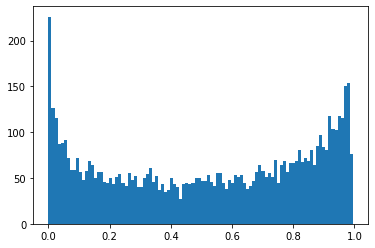

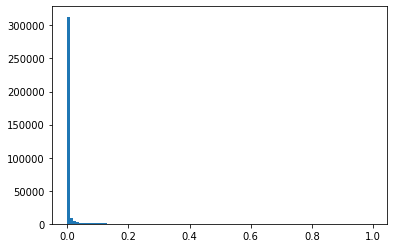

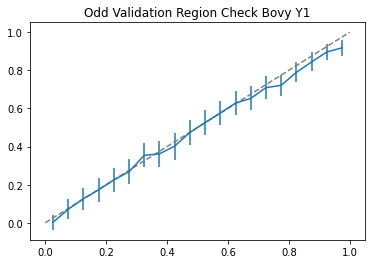

In [33]:
# Figure 3 start:
%matplotlib inline
import matplotlib.pyplot as plt

cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
#call in catalogs
# Assigning CMASS probabilities to Gold Y1 in Stripe 82.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

clean_dmass_prob = assignCMASSProb(clean_cmass_data_des_odd, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_even
, 
                     mag=mag, err=err, filter=filter )

dmass_st82_real = clean_dmass_prob

dmass_st82_val = assignCMASSProb(gold_st82_odd, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_even
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
print('pcenter',pcenter.size)
N, _ = np.histogram(dmass_st82_real['CMASS_PROB'], bins=pbin) # -- true cmass
print('pbin =', pbin)
M, _ = np.histogram(dmass_st82_val['CMASS_PROB'], bins=pbin) # -- dmass

fig, ax = plt.subplots()
ax.hist( dmass_st82_real['CMASS_PROB'], bins= 100)
fig, ax = plt.subplots()
ax.hist( dmass_st82_val['CMASS_PROB'], bins= 100)

#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

frac = N/M
print('frac = ', frac)
print('frac.size', frac.size)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
print('frac err', fracerr.size)
fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
plt.title('Odd Validation Region Check Bovy Y1')
print(fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')

fig.savefig('test_histo_y1_bovy.pdf')